In [3]:
# @title Importando Bibliotecas
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import random


# Data Augmentation

In [4]:
# @title Arrumando Diretórios
destination_path = "./Howard-CloudX-Dataset"
train_dir = destination_path + '/Howard-Cloud-X/train'

class_counts = {}
class_folders = os.listdir(train_dir)

In [9]:
# @title Girando Imagens para Aumentação de Dados (Até 200 Imagens por Classe)
target = 200

def enhance_whites_grays(img):
    # realça pixels de alta luminância e sutilmente desatura para valorizar tons brancos/cinzas
    arr = np.array(img).astype(np.float32)
    # luminância aproximada
    lum = 0.299 * arr[:, :, 0] + 0.587 * arr[:, :, 1] + 0.114 * arr[:, :, 2]
    # escolha um limiar alto (top ~35%) para realçar destaques
    thresh = np.percentile(lum, 65)
    mask = lum >= thresh
    # aumentar brilho/contraste apenas nos pixels claros
    arr[mask] = np.clip(arr[mask] * 1.18 + 12.0, 0, 255)
    # leve desaturação global: mistura entre cor e luminância para favorecer tons cinza
    lum3 = lum[:, :, None]
    arr = np.clip(arr * 0.92 + lum3 * 0.08, 0, 255)
    return Image.fromarray(arr.astype(np.uint8))

augmentations = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),    # 0 graus
        transforms.RandomRotation((90, 90)),  # 90 graus
        transforms.RandomRotation((180, 180)),# 180 graus
        transforms.RandomRotation((270, 270)) # 270 graus
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # aumentar brilho/contraste para destacar áreas claras, reduzir saturação para enfatizar cinzas
    #transforms.ColorJitter(brightness=(1.1, 1.35), contrast=(1.1, 1.5), saturation=(0.6, 0.9), hue=(-0.02, 0.02)),
    #transforms.Lambda(lambda img: enhance_whites_grays(img))
])

for class_name in class_folders:
    class_path = os.path.join(train_dir, class_name)
    
    current_count = len(os.listdir(class_path))
    
    while current_count < target:
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        
        image = Image.open(img_path).convert('RGB')

        augmented_image = augmentations(image)
        
        new_img_name = f'aug_{current_count}_{img_name}'
        new_img_path = os.path.join(class_path, new_img_name)
        
        augmented_image.save(new_img_path)
        
        current_count += 1


Número de tamanhos de imagens diferentes: 500
Menor tamanho de imagem (largura, altura): (214, 136)
Maior tamanho de imagem (largura, altura): (6000, 4000)

Imagens Duplicadas
Sem duplicadas


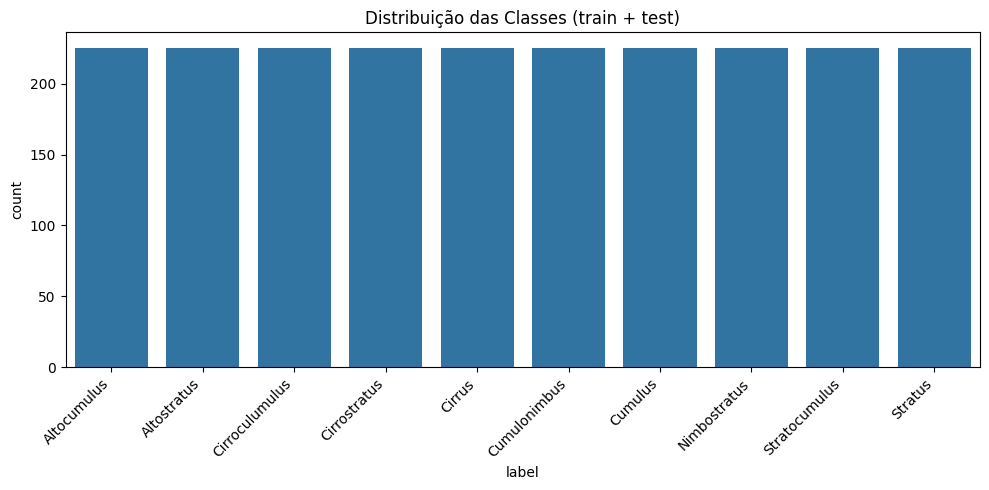

In [10]:
# @title Estatísticas do Dataset depois da Augmentation de Dados

# Define diretório base do dataset de forma robusta
base_dir = os.path.join(destination_path, 'Howard-Cloud-X') if 'destination_path' in globals() else './Howard-CloudX-Dataset/Howard-Cloud-X'

if not os.path.isdir(base_dir):
    raise FileNotFoundError(f"Diretório base não encontrado: {base_dir}")

data_dir = base_dir

# Coleta tamanhos de imagens
image_sizes = set()
for data_type in ['train', 'test']:
    data_type_dir = os.path.join(data_dir, data_type)
    if not os.path.isdir(data_type_dir):
        print(f"Aviso: diretório {data_type_dir} não encontrado.")
        continue
    for class_name in os.listdir(data_type_dir):
        class_dir = os.path.join(data_type_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(file_path) as img:
                        image_sizes.add(img.size)
                except Exception:
                    pass

num_unique_sizes = len(image_sizes)
if image_sizes:
    smallest_size = min(image_sizes, key=lambda x: x[0] * x[1])
    largest_size = max(image_sizes, key=lambda x: x[0] * x[1])
    print(f"\nNúmero de tamanhos de imagens diferentes: {num_unique_sizes}")
    print(f"Menor tamanho de imagem (largura, altura): {smallest_size}")
    print(f"Maior tamanho de imagem (largura, altura): {largest_size}")
else:
    print("Nenhuma imagem encontrada para determinar os tamanhos.")

# Construir DataFrame de caminhos e labels
file_paths = []
labels = []
for data_type in ['train', 'test']:
    data_type_dir = os.path.join(data_dir, data_type)
    if not os.path.isdir(data_type_dir):
        continue
    for class_name in os.listdir(data_type_dir):
        class_dir = os.path.join(data_type_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                file_paths.append(file_path)
                labels.append(class_name)

if not file_paths:
    print("Nenhum arquivo coletado para análise.")
else:
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    duplicates = df[df.duplicated(subset=['file_path'], keep=False)]
    print("\nImagens Duplicadas")
    if not duplicates.empty:
        display(duplicates.sort_values(by='file_path'))
    else:
        print("Sem duplicadas")

    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribuição das Classes (train + test)')
    plt.tight_layout()
    plt.show()

In [ ]:
# @title Treinando EfficientNet (Dropout + Early Stopping + Fine-Tuning Parcial + L1)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report
import os

# Diretórios (usando base_dir já definido anteriormente)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    raise FileNotFoundError(f'Diretórios train/test não encontrados em {base_dir}')

# Hiperparâmetros
batch_size = 32
epochs = 50  # early stopping interrompe antes se necessário
learning_rate = 1e-3
num_workers = 2
val_fraction = 0.15   # fração para validação
patience = 6          # early stopping patience
min_delta = 0.0005    # melhoria mínima no val_loss
l1_lambda = 1e-5      # --- REGULARIZAÇÃO L1 (novo) ---
ft_unfreeze_blocks = 2  # --- FINE-TUNING PARCIAL: nº de últimos blocos a destravar ---

# Transforms mínimos
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # remova se já estiverem nesse tamanho
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset base
full_train_dataset = datasets.ImageFolder(train_dir, transform=common_transforms)
num_classes = len(full_train_dataset.classes)
print(f'Classes ({num_classes}): {full_train_dataset.classes}')

# Split validação
val_size = int(len(full_train_dataset) * val_fraction)
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
print(f'Tamanho treino: {train_size} | validação: {val_size}')

test_dataset = datasets.ImageFolder(test_dir, transform=common_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Modelo EfficientNet pré-treinado
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# --- INÍCIO DROPOUT ---
dropout_rate = 0.5
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),  # Dropout aplicado
    nn.Linear(in_features, num_classes)
)
print(f'Dropout aplicado na classifier com p={dropout_rate}')
# --- FIM DROPOUT ---

# --- INÍCIO FINE-TUNING PARCIAL (novo) ---
# Congela todos os parâmetros das features inicialmente
for param in model.features.parameters():
    param.requires_grad = False
# Descongela os últimos 'ft_unfreeze_blocks' blocos
# EfficientNet_B0 possui model.features como Sequential de blocos; usamos índice negativo
total_blocks = len(model.features)
unfreeze_start = max(0, total_blocks - ft_unfreeze_blocks)
for idx, block in enumerate(model.features):
    if idx >= unfreeze_start:
        for p in block.parameters():
            p.requires_grad = True
print(f'Fine-tuning parcial: {ft_unfreeze_blocks} blocos finais descongelados (de {total_blocks})')
# --- FIM FINE-TUNING PARCIAL ---

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Usando dispositivo: {device}')

# Otimizador (apenas parâmetros treináveis)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Função de treino (inclui L1)
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    running_ce_loss = 0.0  # loss sem L1 para reporting
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        ce_loss = criterion(outputs, labels)
        # --- APLICAÇÃO L1 (novo) ---
        l1_penalty = 0.0
        for p in trainable_params:
            l1_penalty += p.abs().sum()
        l1_penalty = l1_lambda * l1_penalty
        total_loss = ce_loss + l1_penalty  # loss usado para backprop
        # --- FIM L1 ---
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * images.size(0)
        running_ce_loss += ce_loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_ce = running_ce_loss / total
    epoch_acc = correct / total
    print(f'[Treino] Epoch {epoch+1} - Loss(total): {epoch_loss:.4f} | CE: {epoch_ce:.4f} | Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc, epoch_ce

# Validação
def validate(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    val_loss = running_loss / total if total > 0 else 0
    val_acc = correct / total if total > 0 else 0
    print(f'[Val]    Epoch {epoch+1} - Loss: {val_loss:.4f} - Acc: {val_acc:.4f}')
    return val_loss, val_acc

# Teste final
def evaluate_test():
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    acc = correct / total if total > 0 else 0
    print(f'[Teste] Acurácia: {acc:.4f}')
    try:
        print('\nClassification Report (Teste):')
        print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
    except Exception as e:
        print(f'Falha ao gerar classification_report: {e}')

# Early Stopping State
best_val_loss = float('inf')
best_epoch = -1
no_improve_count = 0
best_model_state = None
history = []

for epoch in range(eepochs := epochs):
    train_loss, train_acc, train_ce = train_one_epoch(epoch)
    val_loss, val_acc = validate(epoch)
    history.append({'epoch': epoch+1, 'train_loss_total': train_loss, 'train_loss_ce': train_ce, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc})

    # Early Stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch
        no_improve_count = 0
        best_model_state = model.state_dict()
        print(f'>> Melhora validação: val_loss={val_loss:.4f} (epoch {epoch+1})')
    else:
        no_improve_count += 1
        print(f'>> Sem melhora ({no_improve_count}/{patience})')
        if no_improve_count >= patience:
            print(f'EARLY STOPPING ativado na epoch {epoch+1}. Melhor epoch: {best_epoch+1} com val_loss={best_val_loss:.4f}')
            break

    if (epoch + 1) % 10 == 0:
        evaluate_test()

# Restaurar melhor
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'Modelo restaurado para melhor epoch {best_epoch+1}')

# Avaliação final
evaluate_test()

# Salvar pesos
model_path = 'efficientnet_b0_clouds_best.pt'
torch.save(model.state_dict(), model_path)
print(f'Modelo salvo em {model_path}')

# Salvar histórico
try:
    import pandas as pd
    pd.DataFrame(history).to_csv('training_history.csv', index=False)
    print('Histórico de treino salvo em training_history.csv')
except Exception:
    pass

Classes (10): ['Altocumulus', 'Altostratus', 'Cirroculumulus', 'Cirrostratus', 'Cirrus', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']
Tamanho treino: 1700 | validação: 300
Dropout aplicado na classifier com p=0.5
Usando dispositivo: cuda
[Treino] Epoch 1 - Loss: 1.6377 - Acc: 0.4318
[Treino] Epoch 1 - Loss: 1.6377 - Acc: 0.4318
[Val]    Epoch 1 - Loss: 1.3358 - Acc: 0.4900
>> Melhora validação: val_loss=1.3358 (epoch 1)
[Val]    Epoch 1 - Loss: 1.3358 - Acc: 0.4900
>> Melhora validação: val_loss=1.3358 (epoch 1)
[Treino] Epoch 2 - Loss: 1.0404 - Acc: 0.6282
[Treino] Epoch 2 - Loss: 1.0404 - Acc: 0.6282
[Val]    Epoch 2 - Loss: 1.2309 - Acc: 0.5833
>> Melhora validação: val_loss=1.2309 (epoch 2)
[Val]    Epoch 2 - Loss: 1.2309 - Acc: 0.5833
>> Melhora validação: val_loss=1.2309 (epoch 2)
[Treino] Epoch 3 - Loss: 0.7422 - Acc: 0.7288
[Treino] Epoch 3 - Loss: 0.7422 - Acc: 0.7288
[Val]    Epoch 3 - Loss: 1.3570 - Acc: 0.6067
>> Sem melhora (1/6)
[Val]    Epoch 3 